In [1]:
import pandas as pd
import json
import datetime
import requests
import numpy as np
import math
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
import seaborn as sns
import config
import spotipy
import s3fs
from spotipy.oauth2 import SpotifyClientCredentials
%matplotlib inline 

# Table of Contents

### 1 TicketMaster Face Value Data
    1. Define functions
    2. Get data
    3. Drop duplicates, parking passes
    4. Convert timezones and explode nested data
### 2 SeatGeek Data
    1. Define functions
    2. Get data
    3. Drop duplicates, parking passes
    4. Convert timezones
### 3 StubHub Data
    1. Define functions
    2. Get data
    3. Drop duplicates, parking passes
    4. Convert timezones
### 4 Join DataFrames on Venue & Date
    1. Define functions
    2. Fuzzy match venue names
        1. Manually match unmatched venues
    3. Merge all dataframes
### 5 Spotify Data
    1. Define functions
    2. Generate list of unique artists
    3. Retrieve info from Spotify
    4. Merge Spotify info into master dataframe
### 6 Clean Up Dataframes
    1. Remove unnecessary columns
    2. Rename columns
****
 # Notes
     1. All API keys are stored in a config.py file
     2. All data is stored on a AWS bucket and on local disk
     3. All data collection was performed on Dec 7 2017 for uniformity

***
## 1 TicketMaster Data
Docs: https://developer.ticketmaster.com/products-and-docs/apis/discovery-api/v2/
### 1.1 Define Functions

In [2]:
#DMA and Market numbers
#dma_list = [382,362,264]
#mkt_list =  [42,27,14,36,40,22,5,3,31,10,11,35,47,15]

# Function to get the number of pages of ticketmaster data
def get_number_of_TM_pages(market,source='ticketmaster,frontgate',startDate=None,endDate=None):
    url = 'https://app.ticketmaster.com/discovery/v2/events.json?countryCode=US'
    payload = {'source': source,
               'classificationName': 'music',
               'size': '200',
               'marketId': market,
               'startDateTime' : startDate,
               'endDateTime' : endDate,
               'apikey': config.tm_key}
    r = requests.get(url,params=payload,verify=True)
    json_obj = json.loads(r.text)
    return json_obj.get('page').get('totalPages')

#Get TicketMaster data, return a dataframe
def getTicketMasterData(pageNumber,market,source='ticketmaster,frontgate',startDate=None,endDate=None):
    url = 'https://app.ticketmaster.com/discovery/v2/events.json?countryCode=US'
    payload = {'source': source,
               'marketId': market,
               'classificationName' : 'music',
               'size': '200',
               'page': pageNumber,
               'startDateTime' : startDate,
               'endDateTime' : endDate,
               'apikey': config.tm_key}
    r = requests.get(url,params=payload,verify=True)
    json_response = json.loads(r.text)
    event_info = []
    for event in json_response.get('_embedded',{}).get('events',{}):
         event_info.append({
            'TM_id': str(event.get('id',{})),
            'TM_name' : str(event.get('name',{})),
            'TM_artist': list(str(attraction.get('name')) for attraction in event['_embedded'].get('attractions',{})),
            'TM_venue' : list(str(venue.get('name')) for venue in event['_embedded'].get('venues',{}))[0],
            'TM_venue_city' : list(str(venue.get('city',{}).get('name')) for venue in event['_embedded'].get('venues',{}))[0],
            'TM_venue_state' : list(str(venue.get('state',{}).get('stateCode')) for venue in event['_embedded'].get('venues',{}))[0],
            'TM_venue _lat' : list(str(venue.get('location',{}).get('latitude')) for venue in event['_embedded'].get('venues',{}))[0],
            'TM_venue_long' :list(str(venue.get('location',{}).get('longitude')) for venue in event['_embedded'].get('venues',{}))[0],
            'TM_date' : str(event.get('dates',{}).get('start',{}).get('dateTime',{})),
            'TM_timezone' : str(event.get('dates',{}).get('timezone')),
            'TM_span_multiple_days' : str(event.get('dates',{}).get('spanMultipleDays')),
            'TM_presale_date_start' : list(str(presale.get('startDateTime',{})) for presale in event.get('sales').get('presales',{})),
            'TM_presale_date_end' : list(str(presale.get('endDateTime',{})) for presale in event.get('sales').get('presales',{})),
            'TM_sale_date_start' : str(event.get('sales',{}).get('public',{}).get('startDateTime')),
            'TM_FV_prices': event.get('priceRanges'),
            'TM_promoter': str(event.get('promoter',{}).get('name')),
            'TM_genre' : event.get('classifications'),
         })
    tmDF = pd.DataFrame(event_info)
    return tmDF

#Convert timedate information from UTC to local time
def convert_times(df,times_list,tz_col):
    #Loop through each timezone
    df_list = []
    for tz in df[tz_col].unique():
        #Filter rows by timezone
        mask = (df[tz_col] == tz)
        df_local = df.loc[mask]
        #Loop through each datetime row
        for col in times_list:
            #Convert each column to datetime series, localize to UTC and then convert to proper timezone
            df_local[col] = pd.to_datetime(df_local[col],errors='coerce').dt.tz_localize('UTC').dt.tz_convert(tz)
            #Convert each column to datetime series, localize to UTC and then convert to proper timezone
        df_list.append(df_local)
    df = pd.concat(df_list, axis=0)
    return df

#Explode out columns with nested information
def explode(df,col,index_col):
    df1 = df[col].apply(pd.Series)
    df1 = df1[0].apply(pd.Series)
    df1.index = df[index_col]
    df = df.merge(df1, how='left', left_on=index_col, right_index=True)
    df = df.drop(col,axis=1)
    return df

### 1.2 Query Ticketmaster face value data
### Pull the data and create the data frame
For each city/market, get the number of pages of data, pull all data, and then concatanate the dataframes. Since the Ticketmaster API limits 1000 elements per call, we will divide our calls by event dates.<br>
__Range 1:__ 2017-12-01T00:00:00Z - 2018-02-01T00:00:00Z <br>
__Range 2:__ 2018-02-01T00:00:00Z - 


In [3]:
#Create list of all US Ticketmaster market numbers -- Look at TM API docs for market number info
mkt_list = list(range(1,56)) + list(range(121,126))

In [4]:
tm_df_list = []
p1startDate = '2017-12-06T00:00:00Z'
p1endDate = '2018-02-01T00:00:00Z'

#Create dictionaries of dma/mkt numbers, and number of pages of data
mkt_dict_p1 = dict()
mkt_dict_p2 =dict()

#Get number of pages for face value market items
for mkt in mkt_list:
    mkt_dict_p1[mkt] = get_number_of_TM_pages(market = mkt,
                                              startDate = p1startDate,
                                              endDate = p1endDate)
    mkt_dict_p2[mkt] = get_number_of_TM_pages(market = mkt,
                                              startDate = p1endDate)
    
#Get market data
for mkt in mkt_dict_p1.keys():
    for current_page in range(0,mkt_dict_p1[mkt]):
        tm_df_list.append(getTicketMasterData(market = mkt,
                                              pageNumber = current_page,
                                              startDate = p1startDate,
                                              endDate = p1endDate))
for mkt in mkt_dict_p2.keys():
    for current_page in range(0,mkt_dict_p2[mkt]):
        tm_df_list.append(getTicketMasterData(market = mkt,
                                              pageNumber = current_page,
                                              startDate = p1endDate))
        
#Combine all dataframes for full data on events and face_value prices
tm_df = pd.concat(tm_df_list,axis=0)

tm_df.head()

,TM_FV_prices,TM_artist,TM_date,TM_genre,TM_id,TM_name,TM_presale_date_end,TM_presale_date_start,TM_promoter,TM_sale_date_start,TM_span_multiple_days,TM_timezone,TM_venue,TM_venue _lat,TM_venue_city,TM_venue_long,TM_venue_state
0,"[{'type': 'standard', 'currency': 'USD', 'min'...",[Janet Jackson],2017-12-10T02:00:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...",G5eZZKw1yfkff,Janet Jackson: State of the World Tour,"[2017-05-05T03:00:00Z, 2017-05-05T03:00:00Z, 2...","[2017-05-04T15:00:00Z, 2017-05-04T15:00:00Z, 2...",LIVE NATION MUSIC,2017-05-05T15:00:00Z,False,America/Chicago,Legacy Arena at The BJCC,33.5236525,Birmingham,-86.8137679,AL
1,"[{'type': 'standard', 'currency': 'USD', 'min'...",[Trans-Siberian Orchestra],2017-12-14T01:30:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...",1aeZZfsk3v6ZdGuC,Hallmark Channel Presents Trans-Siberian Orche...,"[2017-09-15T03:00:00Z, 2017-09-15T03:00:00Z, 2...","[2017-09-14T15:00:00Z, 2017-09-14T15:00:00Z, 2...",LIVE NATION MUSIC,2017-09-15T15:00:00Z,False,America/Chicago,Legacy Arena at The BJCC,33.5236525,Birmingham,-86.8137679,AL
2,"[{'type': 'standard', 'currency': 'USD', 'min'...","[Fantasia, Bell Biv Devoe]",2018-01-01T02:00:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...",16OZAuN03ZA8F8dk,New Year's Weekend Celebration Featuring Fanta...,"[2017-11-09T04:00:00Z, 2017-11-09T04:00:00Z, 2...","[2017-11-07T16:00:00Z, 2017-11-07T16:00:00Z, 2...",PROMOTED BY VENUE,2017-11-09T16:00:00Z,False,America/Chicago,BJCC Concert Hall,33.523727,Birmingham,-86.81011,AL
3,"[{'type': 'standard', 'currency': 'USD', 'min'...",[Mannheim Steamroller Christmas],2017-12-28T01:30:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...",17FZv3G61NPaM0E,Mannheim Steamroller Christmas,[2017-07-21T03:00:00Z],[2017-07-19T15:00:00Z],PROMOTED BY VENUE,2017-07-21T15:00:00Z,False,America/Chicago,Von Braun Center Concert Hall,34.726557,Huntsville,-86.589925,AL
4,"[{'type': 'standard', 'currency': 'USD', 'min'...",[Joe Bonamassa],2017-12-09T02:00:00Z,"[{'primary': True, 'segment': {'id': 'KZFzniwn...",1AOZA1dGkd3Czwk,Joe Bonamassa,"[2017-04-07T03:00:00Z, 2017-04-07T14:45:00Z, 2...","[2017-04-04T15:00:00Z, 2017-04-06T15:00:00Z, 2...",PROMOTED BY VENUE,2017-04-07T15:00:00Z,False,America/Chicago,Montgomery Performing Arts Centre,32.379101,Montgomery,-86.312081,AL


### 1.3 Drop Duplicate rows based on Event ID, remove parking passes

We see that there a number of duplicate rows in the DF, this is most likely due to events being part of multiple markets, or some kind of API error. We will simply drop these duplicate rows before moving on.

Additionally, remove any parking pass lisings as those aren't relevant to us

In [5]:
#Drop duplicates
tm_df.drop_duplicates(subset='TM_id',inplace=True)
#Remove parking passes
tm_df = tm_df.loc[~tm_df['TM_venue'].str.lower().str.contains('parking')]
tm_df = tm_df.loc[~tm_df['TM_name'].str.lower().str.contains('parking')]

### 1.4 Convert datetime columns, explode nested information
Currently the four columns with datetime information are a mess. Some are of type dict, some are nested in lists, and all are in the UTC timezone. We can look and see that in timedate columns with lists of dates, the timedates are identitical, so we can unnest datetimes by simply taking the first element of the list.

There are also columns with some nested info (Price, Genre) which we would like to look at, so we'll explode those columns and unnest the data

In [6]:
# Convert all datetime columns to dtype string, and unnest objects
tm_df['TM_presale_date_end'] = tm_df['TM_presale_date_end'].str[0]
tm_df['TM_presale_date_start'] = tm_df['TM_presale_date_start'].str[0]
# Filter rows by timezone and create a new dataframe per timezone, loop over each datetime column to convert objects to their proper timezone 
col_list = ['TM_presale_date_end','TM_presale_date_start','TM_date','TM_sale_date_start']
tm_df = convert_times(df=tm_df,times_list=col_list,tz_col='TM_timezone')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
#Explode price column
tm_df = explode(tm_df,col='TM_FV_prices',index_col='TM_id')
#Unnest genre info and clean up data in exploded columns
tm_df = explode(tm_df,'TM_genre','TM_id')
for col in ['genre','segment','subGenre']:
    tm_df[col] = tm_df[col].map(lambda x: dict(x).get('name',{}))
tm_df.head()

/usr/local/lib/python3.6/site-packages/pandas/core/indexes/api.py:57: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  union = _union_indexes(indexes)
/usr/local/lib/python3.6/site-packages/pandas/core/indexes/api.py:87: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


,TM_artist,TM_date,TM_id,TM_name,TM_presale_date_end,TM_presale_date_start,TM_promoter,TM_sale_date_start,TM_span_multiple_days,TM_timezone,...,max,min,type_x,0,genre,primary,segment,subGenre,subType,type_y
0,[Janet Jackson],2017-12-09 20:00:00-06:00,G5eZZKw1yfkff,Janet Jackson: State of the World Tour,2017-05-04 22:00:00-05:00,2017-05-04 10:00:00-05:00,LIVE NATION MUSIC,2017-05-05 10:00:00-05:00,False,America/Chicago,...,648.0,13.0,standard,NaN,Rock,True,Music,Pop,"{'id': 'KZFzBErXgnZfZ7v7lJ', 'name': 'Undefined'}","{'id': 'KZAyXgnZfZ7v7nI', 'name': 'Undefined'}"
1,[Trans-Siberian Orchestra],2017-12-13 19:30:00-06:00,1aeZZfsk3v6ZdGuC,Hallmark Channel Presents Trans-Siberian Orche...,2017-09-14 22:00:00-05:00,2017-09-14 10:00:00-05:00,LIVE NATION MUSIC,2017-09-15 10:00:00-05:00,False,America/Chicago,...,80.5,32.0,standard,NaN,World,True,Music,World,"{'id': 'KZFzBErXgnZfZ7v7lJ', 'name': 'Undefined'}","{'id': 'KZAyXgnZfZ7v7nI', 'name': 'Undefined'}"
2,"[Fantasia, Bell Biv Devoe]",2017-12-31 20:00:00-06:00,16OZAuN03ZA8F8dk,New Year's Weekend Celebration Featuring Fanta...,2017-11-08 22:00:00-06:00,2017-11-07 10:00:00-06:00,PROMOTED BY VENUE,2017-11-09 10:00:00-06:00,False,America/Chicago,...,105.0,55.0,standard,NaN,R&B,True,Music,R&B,"{'id': 'KZFzBErXgnZfZ7v7lJ', 'name': 'Undefined'}","{'id': 'KZAyXgnZfZ7v7nI', 'name': 'Undefined'}"
3,[Mannheim Steamroller Christmas],2017-12-27 19:30:00-06:00,17FZv3G61NPaM0E,Mannheim Steamroller Christmas,2017-07-20 22:00:00-05:00,2017-07-19 10:00:00-05:00,PROMOTED BY VENUE,2017-07-21 10:00:00-05:00,False,America/Chicago,...,69.0,69.0,standard,NaN,New Age,True,Music,New Age,"{'id': 'KZFzBErXgnZfZ7v7lJ', 'name': 'Undefined'}","{'id': 'KZAyXgnZfZ7v7nI', 'name': 'Undefined'}"
4,[Joe Bonamassa],2017-12-08 20:00:00-06:00,1AOZA1dGkd3Czwk,Joe Bonamassa,2017-04-06 22:00:00-05:00,2017-04-04 10:00:00-05:00,PROMOTED BY VENUE,2017-04-07 10:00:00-05:00,False,America/Chicago,...,149.0,89.0,standard,NaN,Blues,True,Music,Blues,"{'id': 'KZFzBErXgnZfZ7v7lJ', 'name': 'Undefined'}","{'id': 'KZAyXgnZfZ7v7nI', 'name': 'Undefined'}"


***
## 2 Download Resale Data from SeatGeek API
SeatGeek API docs: http://platform.seatgeek.com
### 2.1 Define functions

In [8]:
#Connect to SeatGeek API and determine number of pages of information
def get_SeatGeek_Pages():
    url = 'https://api.seatgeek.com/2/events?format=json'
    payload = {'per_page' : 1000,
               'taxonomies.name':'concert',
               'client_id':  config.sg_key,
              }
    r = requests.get(url, params=payload,verify=True)
    json_obj = json.loads(r.text)
    
    #Return the total number of JSON items divided by the number of page to get page count
    return math.ceil(json_obj['meta']['total']/json_obj['meta']['per_page'])

#Connect to SeatGeek API and download JSON data, format it into pandas dataframe
def get_SeatGeek_data(page=1):
    url = 'https://api.seatgeek.com/2/events?format=json'
    payload = {'per_page' : 1000,
               'page' : page,
               'taxonomies.name':'concert',
               'venue.country' : 'US',
               'client_id': config.sg_key,
              }
    r = requests.get(url,params=payload,verify=True)
    json_obj = json.loads(r.text)
    info_list = []
    for event in json_obj['events']:
        info_list.append(
         {'SG_event_id' : str(event.get('id',{})),
         'SG_listing_count' : str(event.get('stats',{}).get('listing_count',{})),
         'SG_average_price' : str(event.get('stats',{}).get('average_price',{})),
         'SG_min_price' : str(event.get('stats',{}).get('lowest_price',{})),
         'SG_max_price' : str(event.get('stats',{}).get('highest_price',{})),
         'SG_title' : str(event.get('title',{})),
         'SG_date' : str(event.get('datetime_local',{})),
         'SG_artists' : list(str(performer.get('name',{})) for performer in event.get('performers',{})),
         'SG_artists_score' : list(str(performer.get('score',{})) for performer in event.get('performers',{})),
         'SG_artists_id' : list(str(performer.get('id',{})) for performer in event.get('performers',{})),
         'SG_venue' : str(event.get('venue',{}).get('name',{})),
         'SG_venue_city' : str(event.get('venue',{}).get('city',{})),
         'SG_venue_state' : str(event.get('venue',{}).get('state',{})),
         'SG_venue_score' : str(event.get('venue',{}).get('score',{}))
                               })
    sg_df = pd.DataFrame(info_list)
    return sg_df

def localize_times(df, time_col, tz_col):
    df_list = []
    for tz in df[tz_col].unique():
        #Filter rows by timezone
        mask = (df[tz_col] == tz)
        df_local = df.loc[mask]
        df_local[time_col] = pd.to_datetime(df_local[time_col],
                                                    errors='coerce').dt.tz_localize(None).dt.tz_localize(tz)
        df_list.append(df_local)
        df = pd.concat(df_list, axis=0)
    return df

### 2.2 Download SeatGeek data into DataFrame

In [9]:
sgdf_list = []

#Find the total number of pages in 
total_pages = get_SeatGeek_Pages()

#Loop through the number pages of data and combine data into single dataframe
for pageNum in range(1,total_pages+1):
    sgdf_list.append(get_SeatGeek_data(page=pageNum))
sg_df = pd.concat(sgdf_list,axis=0)
sg_df.head()

,SG_artists,SG_artists_id,SG_artists_score,SG_average_price,SG_date,SG_event_id,SG_listing_count,SG_max_price,SG_min_price,SG_title,SG_venue,SG_venue_city,SG_venue_score,SG_venue_state
0,[Omer Avital],[121831],[0.4499999881],None,2017-12-06T03:30:00,4126436,None,None,None,Omer Avital,"Dizzy's Club Coca-Cola, Lincoln Center",New York,0.0,NY
1,[CLOSED],[269974],[0.5199999809],None,2017-12-06T03:30:00,4138645,None,None,None,CLOSED,The Jazz Kitchen,Indianapolis,0.0,IN
2,[Josh Abbott Band],[7262],[0.4600000083],None,2017-12-06T03:30:00,4126536,None,None,None,Josh Abbott Band,Hurricane Harry's,College Station,0.2912119925,TX
3,[Eiffel Tower Experience],[605657],[0.0],None,2017-12-06T03:30:00,3963294,None,None,None,Eiffel Tower Experience,Paris Las Vegas,Las Vegas,0.4538879991,NV
4,"[Keiko Matsui, Euge Groove]","[4995, 16924]","[0.4300000072, 0.4099999964]",None,2017-12-06T03:30:00,4070426,None,None,None,Keiko Matsui with Euge Groove,Sycuan Casino,El Cajon,0.4364410043,CA


### 2.3 Drop Duplicates, remove parking passes & Convert to localized datetimes
Once again, we'll drop duplicate rows based on event ID, 

In [10]:
#Drop duplicates
sg_df.drop_duplicates(subset='SG_event_id',inplace=True)
#Remove parking passes
sg_df = sg_df.loc[~sg_df['SG_venue'].str.lower().str.contains('parking')]
sg_df = sg_df.loc[~sg_df['SG_title'].str.lower().str.contains('parking')]

***
### 2.4 Convert datetimes

In [11]:
#Create SH column for timezone
state2timezone = { 'AK': 'US/Alaska', 'AL': 'US/Central', 
                  'AR': 'US/Central', 'AS': 'US/Samoa', 
                  'AZ': 'US/Mountain', 'CA': 'US/Pacific', 
                  'CO': 'US/Mountain', 'CT': 'US/Eastern', 
                  'D.c.' : 'US/Eastern', 
                  'DC': 'US/Eastern', 'DE': 'US/Eastern', 
                  'FL': 'US/Eastern', 'GA': 'US/Eastern', 
                  'HI': 'US/Hawaii', 'IA': 'US/Central', 
                  'ID': 'US/Mountain', 'IL': 'US/Central', 
                  'IN': 'US/Eastern', 'KS': 'US/Central', 
                  'KY': 'US/Eastern', 'LA': 'US/Central', 
                  'MA': 'US/Eastern', 'MD': 'US/Eastern', 
                  'ME': 'US/Eastern', 'MI': 'US/Eastern', 
                  'MN': 'US/Central', 'MO': 'US/Central', 
                  'MP': 'Pacific/Guam', 'MS': 'US/Central', 
                  'MT': 'US/Mountain', 'NC': 'US/Eastern', 
                  'ND': 'US/Central', 'NE': 'US/Central', 
                  'NH': 'US/Eastern', 'NJ': 'US/Eastern', 
                  'NM': 'US/Mountain', 'NV': 'US/Pacific', 
                  'NY': 'US/Eastern', 'OH': 'US/Eastern', 
                  'OK': 'US/Central', 'OR': 'US/Pacific', 
                  'PA': 'US/Eastern', 'PR': 'America/Puerto_Rico', 
                  'RI': 'US/Eastern', 'SC': 'US/Eastern', 
                  'SD': 'US/Central', 'TN': 'US/Central', 
                  'TX': 'US/Central', 'UT': 'US/Mountain', 
                  'VA': 'US/Eastern', 'VI': 'America/Virgin', 
                  'VT': 'US/Eastern', 'WA': 'US/Pacific', 
                  'WI': 'US/Central', 'WV': 'US/Eastern', 
                  'WY': 'US/Mountain'}

In [12]:
#Convert SG dates to datetime object and localize
#Create timezone column
sg_df['SG_timezone'] = sg_df['SG_venue_state'].map(state2timezone)
#Drop rows without a valid timezone -- Non-events and Canadian events
sg_df = sg_df.loc[~sg_df['SG_timezone'].isnull()]
#Clear timezones and re-localize all datetimes to their respective timezones
sg_df = localize_times(sg_df,'SG_date','SG_timezone')
sg_df.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,SG_artists,SG_artists_id,SG_artists_score,SG_average_price,SG_date,SG_event_id,SG_listing_count,SG_max_price,SG_min_price,SG_title,SG_venue,SG_venue_city,SG_venue_score,SG_venue_state,SG_timezone
0,[Omer Avital],[121831],[0.4499999881],None,2017-12-06 03:30:00-05:00,4126436,None,None,None,Omer Avital,"Dizzy's Club Coca-Cola, Lincoln Center",New York,0.0,NY,US/Eastern
1,[CLOSED],[269974],[0.5199999809],None,2017-12-06 03:30:00-05:00,4138645,None,None,None,CLOSED,The Jazz Kitchen,Indianapolis,0.0,IN,US/Eastern
5,"[Cory Branan, The Whiskey Gentry]","[11704, 38481]","[0.4099999964, 0.4799999893]",None,2017-12-06 19:30:00-05:00,4099564,None,None,None,Cory Branan with The Whiskey Gentry,The Evening Muse,Charlotte,0.396239996,NC,US/Eastern
6,"[Fantasia, Fantasia Barrino]","[2370, 16896]","[0.5500000119, 0.5500000119]",None,2017-12-06 19:30:00-05:00,4073070,None,None,None,Fantasia,Durham Performing Arts Center,Durham,0.5500950217,NC,US/Eastern
7,[GWAR],[826],[0.4600000083],None,2017-12-06 19:30:00-05:00,4001812,None,None,None,GWAR,The Ritz Ybor,Tampa,0.5133380294,FL,US/Eastern


***
## 3 StubHub Data
Connect to StubHub API and download data
Stubhub API docs: https://developer.stubhub.com/store/site/pages/doc-reference.jag

### 3.1 Define Functions

In [13]:
#Get number of pages of data
def get_SH_pages():
    url = 'https://api.stubhub.com/search/catalog/events/v3/'
    payload = {'minAvailableTickets':1, 
              'categoryName':'Concert',
              'country' : 'US'}
    headers = {'Authorization': 'Bearer ' + config.sh_key} # Insert StubHub API Key here
    r = requests.get(url, params=payload, headers=headers, verify=True)
    json_response = json.loads(r.text)
    return math.ceil(json_response.get('numFound',{})/500)

#Connect to StubHub API and put data into DataFrame
def get_SH_data(start):
    url = 'https://api.stubhub.com/search/catalog/events/v3/'
    payload = {'minAvailableTickets':1, 
              'categoryName':'Concert',
               'rows' : 500,
               'start' : start,
               'country' : 'US'}
    headers = {'Authorization': 'Bearer ' + config.sh_key} # Insert StubHub API Key here
    r = requests.get(url, params=payload, headers=headers, verify=True)
    json_response = json.loads(r.text)
    event_info = []
    for event in json_response.get('events',{}):
            event_info.append({
                    'SH_artist':list(str(artist.get('name',{})) for artist in event.get('ancestors',{}).get('performers',{})),
                    'SH_date':str(event.get('eventDateLocal',{})),
                    'SH_event_id':str(event.get('id',{})),
                    'SH_min_price':str(event.get('ticketInfo',{}).get('minPrice',{})),
                    'SH_max_price':str(event.get('ticketInfo',{}).get('maxPrice')),
                    'SH_total_postings':str(event.get('ticketInfo',{}).get('totalPostings')),
                    'SH_total_tickets':str(event.get('ticketInfo',{}).get('totalTickets')),
                    'SH_venue':str(event['venue'].get('name')),
                    'SH_venue_city':str(event['venue'].get('city')),
                    'SH_venue_state':str(event['venue'].get('state'))
                })
    TicketData = pd.DataFrame(event_info)
    return TicketData

### 3.2 Gather data and concat into a dataframe

In [14]:
pages = get_SH_pages()
sh_df_list = []
for page in range(pages):
    start_place = page * 500
    sh_df_list.append(get_SH_data(start=start_place))
sh_df = pd.concat(sh_df_list,axis=0)
sh_df.head()

,SH_artist,SH_date,SH_event_id,SH_max_price,SH_min_price,SH_total_postings,SH_total_tickets,SH_venue,SH_venue_city,SH_venue_state
0,[Badfish],2018-02-07T20:00:00-0500,103196370,106.02,106.02,1,8,The Temple Lancaster,Lancaster,PA
1,[3 Doors Down],2018-02-02T20:00:00-0600,103266898,149.25,149.25,1,2,Ho Chunk Casino,Baraboo,WI
2,[3 Doors Down],2018-01-20T20:00:00-0800,103266895,236.5,107.03,14,36,Silver Legacy Casino,Reno,NV
3,[DigiTour],2017-12-23T16:01:00-0500,103247128,50.5,50.5,2,6,Gramercy Theatre Parking Lots,New York,NY
4,[Trans-Siberian Orchestra],2017-12-30T20:01:00-0600,103195564,62.49,62.49,1,2,Xcel Energy Center Parking Lots,Saint Paul,MN


### 3.3 Convert to datetimes, drop duplicates

In [15]:
#Drop Duplicates
sh_df.drop_duplicates(inplace=True, subset='SH_event_id')
#Drop Parking Passes
sh_df = sh_df.loc[~sh_df['SH_venue'].str.lower().str.contains('parking')]
#Map timezone column from state
sh_df['SH_timezone'] = sh_df['SH_venue_state'].map(state2timezone)
#Convert to local timezones
sh_df = convert_times(sh_df,['SH_date'],'SH_timezone')
sh_df.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,SH_artist,SH_date,SH_event_id,SH_max_price,SH_min_price,SH_total_postings,SH_total_tickets,SH_venue,SH_venue_city,SH_venue_state,SH_timezone
0,[Badfish],2018-02-07 20:00:00-05:00,103196370,106.02,106.02,1,8,The Temple Lancaster,Lancaster,PA,US/Eastern
5,[The Get Up Kids],2017-12-29 19:30:00-05:00,103247112,51.7,37.19,3,20,The Lost Horizon,Syracuse,NY,US/Eastern
8,[Michael Stanley],2017-12-23 19:30:00-05:00,103197267,570.1,115.3,30,99,Hard Rock Rocksino,Northfield,OH,US/Eastern
10,[Mike and the mechanics],2018-03-28 20:00:00-04:00,103196981,349.3,170.49,3,9,Rams Head Tavern On Stage,Annapolis,MD,US/Eastern
12,[Umphrey's McGee],2018-02-01 19:00:00-05:00,103267408,72.69,62.48,7,42,Express Live,Columbus,OH,US/Eastern


***
## 4 Join dataframes on venue name fuzzy match and datetime
### 4.1 Define functions

In [16]:
#Find a fuzzy match venue with Ticketmaster venue
def venue_match(row):
    
    #If an exact match exists of venue name, city, and state, return as 100% match
    mask =(tm1['TM_venue'] == row.iloc[0]) & (tm1['TM_venue_city'] == row.iloc[1]) & (tm1['TM_venue_state'] == row.iloc[2])
    if not (tm1.loc[mask]).empty:
        return row.iloc[0], row.iloc[0],'MATCH', 100
    
    #If there is not an exact match, look for a fuzzy match where city and state names match up
    else:
        new_name, score = process.extractOne(row.iloc[0], tm_venues)
        if score < 90 \
        or any(tm1['TM_venue_city'].loc[tm1['TM_venue'] == new_name] != row.iloc[1])\
        or any(tm1['TM_venue_state'].loc[tm1['TM_venue'] == new_name] != row.iloc[2]):
            return row.iloc[0], row.iloc[0],'NO MATCH',score
        else: 
            return new_name, row.iloc[0], 'MATCH',score

### 4.2 Find fuzzy matches of TM venue names for SH and SG venues

In [17]:
#Create DF of unique Ticketmaster venues,and their cities and states
tm1 = tm_df[['TM_venue','TM_venue_city','TM_venue_state']].drop_duplicates()
#Create DF of unique StubHub venues,and their cities and states
sh1 = sh_df[['SH_venue','SH_venue_city','SH_venue_state']].drop_duplicates()
#Create DF of unique SeatGeek venues,and their cities and states
sg1 = sg_df[['SG_venue','SG_venue_city','SG_venue_state']].drop_duplicates()
#Create list of unique TM venue names to compare against
tm_venues = tm1['TM_venue'].unique()

In [18]:
#Create DataFrames of new venue names and scores
sh_venue_score = pd.DataFrame(sh1.apply(venue_match,axis=1).tolist(),columns=['TM_venue','SH_venue','MATCH','Score'])
sg_venue_score = pd.DataFrame(sg1.apply(venue_match,axis=1).tolist(),columns=['TM_venue','SG_venue','MATCH','Score'])

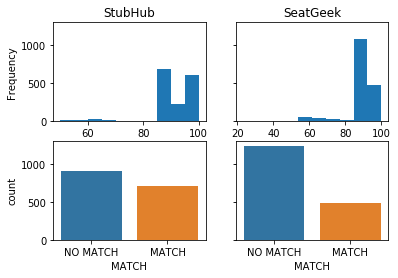

In [19]:
#Plot matches and scores
fig, axs = plt.subplots(2,2,sharey=True)
sh_venue_score['Score'].plot(kind='hist',ax=axs[0,0],title='StubHub')
sg_venue_score['Score'].plot(kind='hist',ax=axs[0,1],title='SeatGeek')
sns.countplot(x='MATCH', data=sh_venue_score,ax=axs[1,0])
sns.countplot(x='MATCH', data=sg_venue_score,ax=axs[1,1])

In [ ]:
sg_venue_score.loc[sg_venue_score['Score'] < 90].head(900)

In [ ]:
sh_venue_score.loc[sh_venue_score['Score'] < 90].head(900)

### 4.2.1 Manually correct visible matching errors
Upon visible inspection we can correct a few misclassified venue names. However, it looks like most of the unclassified venues are smaller bars and clubs, whick Ticketmaster doesn't have tickets for

In [20]:
sh_venue_score['TM_venue'].loc[sh_venue_score['SH_venue'] == 'Wiltern Theatre'] = 'The Wiltern'
sg_venue_score['TM_venue'].loc[sg_venue_score['SG_venue'] == 'U.S. Cellular Center'] = 'U.S. Cellular Center Asheville'
sh_venue_score['TM_venue'].loc[sh_venue_score['SH_venue'] == 'Verizon Wireless Center in Mankato'] = 'Verizon Center'

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### 4.3 Map TM venue names and merge to respective DFs

In [21]:
#Merge TM venues to SH and SG DFs
sg_df = sg_df.merge(sg_venue_score[['TM_venue','SG_venue']], on = 'SG_venue',how='left')
sh_df = sh_df.merge(sh_venue_score[['TM_venue','SH_venue']], on = 'SH_venue',how='left')

In [22]:
#Merge all to a master_df
master_df = tm_df.merge(sg_df,left_on=['TM_date','TM_venue'],right_on=['SG_date','TM_venue'],how='left')
master_df = master_df.merge(sh_df,left_on=['TM_date','TM_venue'],right_on=['SH_date','TM_venue'],how='left')

In [23]:
#Drop rows with missing face value prices, or resale prices
master_df.dropna(subset=['SH_max_price','SG_max_price'],how='all',inplace=True,axis=0)
master_df.dropna(subset=['max'],inplace=True,axis=0)
master_df.shape

(5102, 52)

***
## 5 Retrieve Spotify Artist Information
Make a list unique artist names, get spotify popularity and follower info, then map it back to the master_df
Spotify API: https://developer.spotify.com/web-api/
Spotipy Wrapper: http://spotipy.readthedocs.io/en/latest/
### 5.1 Define Functions

In [24]:
#Fill in missing TM artist data with that of SeatGeek or Stubhub
def fill_na_artists(row):
    #If TM artist name is missing:
    if (len(row['TM_artist']) == 0):
        #If SG artist name is missing
        if (row['SG_artists'] == 'NaN'):
            #Fill with SH artist name
            row['TM_artist'] = row['SH_artist']
        #Else fill with SG artist name
        else:
            row['TM_artist'] = row['SG_artists']
    return row['TM_artist']

#Get data from Spotify
def get_artist_data(artist):
    results = sp.search(q='artist:' + artist, type='artist',limit=1)
    try:
        #Retrieve artist follower and popularity info
        followers = results.get('artists').get('items')[0].get('followers').get('total')
        popularity = results.get('artists').get('items')[0].get('popularity')
    except IndexError:
        #Return NaN if no info is found for an artist
        followers = 'NaN'
        popularity = 'NaN'
    return followers, popularity

#Map artist to popularity and followers values
def map_artist(row):
    followers_list = list()
    popularity_list = list()
    try:
        for artist in row:
            artist_followers = artist_followers_dict.get(artist,'NaN')
            artist_popularity = artist_popularity_dict.get(artist,'NaN')
            followers_list.append(artist_followers)
            popularity_list.append(artist_popularity)
    except TypeError:
            followers_list.append('NaN')
            popularity_list.append('NaN')
    return followers_list, popularity_list

### 5.2 Generate list of unique artists

In [25]:
#Fill in missing artist info
master_df['TM_artist'] = master_df[['TM_artist','SG_artists','SH_artist']].apply(fill_na_artists,axis=1)
#Create a new dataframe of unique artist names
artist_df = pd.DataFrame(master_df['TM_artist'].apply(pd.Series).stack().reset_index(drop=True),columns=['artist'])
artist_df = artist_df.drop_duplicates()

### 5.3 Retrieve data from Spotify using Spotipy API wrapper

In [26]:
#Input login credentials
client_credentials_manager = SpotifyClientCredentials(
    client_id=config.spotify_key,client_secret=config.spotify_secret)
#Initiate Spotify connection object
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
#Retrieve follower and popularity info for each artist
artist_df['spotify_followers'],artist_df['spotify_popularity']= zip(*artist_df['artist'].apply(get_artist_data))
#How many artists we coulnd't find info for
artist_df.loc[artist_df['spotify_followers'] =='NaN'].count()

retrying ...1secs


artist                300
spotify_followers     300
spotify_popularity    300
dtype: int64

### 5.4 Merge data with Master DF

In [27]:
#Create dictionary of artist and followers values
artist_followers_dict = dict(zip(artist_df['artist'],artist_df['spotify_followers']))
#Create dictionary of artist and popularity values
artist_popularity_dict = dict(zip(artist_df['artist'],artist_df['spotify_popularity']))
#Map artist data from dictionaries into the DF
master_df['spotify_followers'], master_df['spotify_popularity'] = zip(*master_df['TM_artist'].map(map_artist))

***
## 6 Clean Up Dataframes
### 6.1 Drop unneccesary columns

In [28]:
drop_list = ['currency','type_x',0,'segment','primary','type_y','TM_timezone','SG_artists','SG_artists_id','SG_date','SG_event_id',
             'SG_title','SG_venue','SG_venue_city','SG_venue_state','SG_timezone','SH_artist','SH_date',
             'SH_event_id','SH_venue','SH_venue_city','SH_venue_state','SH_timezone']
master_df.drop(drop_list,axis=1,inplace=True)

### 6.2 Rename columns

In [29]:
new_cols = {
            'TM_artist' : 'artists',
            'TM_date': 'date', 
            'TM_id' : 'TM_id', 
            'TM_name' : 'event_title', 
            'TM_presale_date_end' : 'presale_date_end',
            'TM_presale_date_start' : 'presale_date_start', 
            'TM_promoter' : 'promoter', 
            'TM_sale_date_start' : 'TM_sale_date_start', 
            'TM_span_multiple_days' : 'span multiple days', 
            'TM_venue' : 'venue', 
            'TM_venue_city':'venue_city' , 
            'TM_venue_state':'venue_state',
            'max':'TM_max', 
            'min':'TM_min', 
            'subGenre':'subGenre', 
            'subType':'event_type',
           }
master_df = master_df.rename(new_cols,axis=1)
master_df.head()

,artists,date,TM_id,event_title,presale_date_end,presale_date_start,promoter,TM_sale_date_start,span multiple days,venue,...,SG_listing_count,SG_max_price,SG_min_price,SG_venue_score,SH_max_price,SH_min_price,SH_total_postings,SH_total_tickets,spotify_followers,spotify_popularity
3,[Mannheim Steamroller Christmas],2017-12-27 19:30:00-06:00,17FZv3G61NPaM0E,Mannheim Steamroller Christmas,2017-07-20 22:00:00-05:00,2017-07-19 10:00:00-05:00,PROMOTED BY VENUE,2017-07-21 10:00:00-05:00,False,Von Braun Center Concert Hall,...,NaN,NaN,NaN,NaN,266.02,111.7,16,69,[NaN],[NaN]
4,[Joe Bonamassa],2017-12-08 20:00:00-06:00,1AOZA1dGkd3Czwk,Joe Bonamassa,2017-04-06 22:00:00-05:00,2017-04-04 10:00:00-05:00,PROMOTED BY VENUE,2017-04-07 10:00:00-05:00,False,Montgomery Performing Arts Centre,...,NaN,NaN,NaN,NaN,356.5,86.3,10,28,[298790],[64]
5,[Jennifer Nettles],2017-12-14 20:00:00-06:00,1kFZvKA_GA18ELF,Jennifer Nettles,2017-08-24 22:00:00-05:00,2017-08-24 10:00:00-05:00,None,2017-08-25 10:00:00-05:00,False,Von Braun Center Concert Hall,...,NaN,NaN,NaN,NaN,152.5,86.5,34,130,[83152],[54]
6,[Home Free],2017-12-21 19:30:00-06:00,1AOZAGvGkdbRb83,Home Free: A Country Christmas,2017-08-10 22:00:00-05:00,2017-08-07 10:00:00-05:00,PROMOTED BY VENUE,2017-08-11 10:00:00-05:00,False,Montgomery Performing Arts Centre,...,NaN,NaN,NaN,NaN,165.0,46.88,11,49,[84183],[62]
7,[Styx],2018-01-18 19:30:00-06:00,G5viZfUJQQSgi,Styx,2017-11-16 22:00:00-06:00,2017-11-15 10:00:00-06:00,PROMOTED BY VENUE,2017-11-17 10:00:00-06:00,False,BancorpSouth Arena,...,NaN,NaN,NaN,NaN,213.1,76.9,26,105,[307254],[65]


***
## Save Data

In [30]:
# Create a function to save data to AWS
def save_to_AWS(save_list):
    for key, df in save_list.items():
        bytes_to_write = df.to_csv(None).encode()
        path = 's3://cap1project/csv_files/{}.csv'
        fs = s3fs.S3FileSystem(key=config.aws_key, 
                               secret=config.aws_secret)
        with fs.open(path.format(key), 'wb') as f:
            f.write(bytes_to_write)
            
def save_to_Disk(save_list):
    for key, df in save_list.items():
        df.to_csv(key)
            
            

In [31]:
save_list = {
             'tm_df' : tm_df,
             'sg_df': sg_df,
             'sh_df': sh_df,
             'sh_venue_score90' : sh_venue_score,
             'sg_venue_score90' : sg_venue_score,
             'artist_df' : artist_df,
             'master_df' : master_df
            }

save_to_AWS(save_list)
save_to_Disk(save_list)
%store tm_df
%store sg_df
%store sh_df
%store sh_venue_score
%store sg_venue_score

Stored 'save_list' (dict)
